## Import Packages

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# Load Dataset

In [40]:
dir = 'refined_dataset'
listdir = os.listdir(dir)

print(listdir)
print("The number of dataset :", len(listdir))

['B07_discharge_soh.csv', 'B05_discharge_soh.csv', 'B46_discharge_soh.csv', 'B48_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B47_discharge_soh.csv', 'B18_discharge_soh.csv']
The number of dataset : 8


In [41]:
num = ['B05', 'B07', 'B18', 'B33', 'B34', 'B46', 'B47', 'B48']
for i in range(len(listdir)):
    path = os.path.join(os.getcwd(), 'refined_dataset', num[i] + '_discharge_soh.csv')
    df = pd.read_csv(path)
    vec = df[['cycle', 'capacity', 'SOH', 'temperature']]
    globals()['data_{}'.format(num[i])] = vec


## Display the loaded data for B05 as an example

In [42]:
data_B05 = globals()['data_B05']
print(data_B05.head())

   cycle  capacity       SOH  temperature
0      1  1.856487  0.928244    24.330034
1      1  1.856487  0.928244    24.325993
2      1  1.856487  0.928244    24.389085
3      1  1.856487  0.928244    24.544752
4      1  1.856487  0.928244    24.731385


## Print the shape of each datset

In [45]:
for i in range(len(listdir)):
    print("Shape of data_{}: {}".format(num[i], np.shape(globals()['data_{}'.format(num[i])])))

Shape of data_B05: (50285, 4)
Shape of data_B07: (50285, 4)
Shape of data_B18: (34866, 4)
Shape of data_B33: (42200, 4)
Shape of data_B34: (45909, 4)
Shape of data_B46: (23478, 4)
Shape of data_B47: (23478, 4)
Shape of data_B48: (23478, 4)


## Prepare the dataset for training and testing

In [46]:
dataset = data_B05[['SOH', 'temperature']].values
cycle = data_B05['cycle'].values

## Normalize the Dataset

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Split train and test dataset

In [48]:
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

11739 11739


## Create Dataset with look_back

In [49]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # SOH is the first column
    return np.array(dataX), np.array(dataY)


look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

## Reshape input to be [samples,timeStamps , features]

In [50]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

print(trainX.shape)
print(testX.shape)


(11738, 1, 2)
(11738, 1, 2)


## Training the LSTM model

In [51]:
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=20, validation_data=(testX, testY), verbose=1, shuffle=False)

Epoch 1/100
587/587 [==============================] - 3s 3ms/step - loss: 0.1027 - val_loss: 0.0649
Epoch 2/100
587/587 [==============================] - 2s 3ms/step - loss: 0.0350 - val_loss: 0.0576
Epoch 3/100
587/587 [==============================] - 2s 3ms/step - loss: 0.0291 - val_loss: 0.0501
Epoch 4/100
587/587 [==============================] - 2s 3ms/step - loss: 0.0240 - val_loss: 0.0436
Epoch 5/100
587/587 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0388
Epoch 6/100
587/587 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0336
Epoch 7/100
587/587 [==============================] - 2s 3ms/step - loss: 0.0122 - val_loss: 0.0275
Epoch 8/100
587/587 [==============================] - 2s 3ms/step - loss: 0.0088 - val_loss: 0.0224
Epoch 9/100
587/587 [==============================] - 2s 3ms/step - loss: 0.0062 - val_loss: 0.0183
Epoch 10/100
587/587 [==============================] - 2s 3ms/step - loss: 0.0041 - val_lo

## Plotting training and validation loss

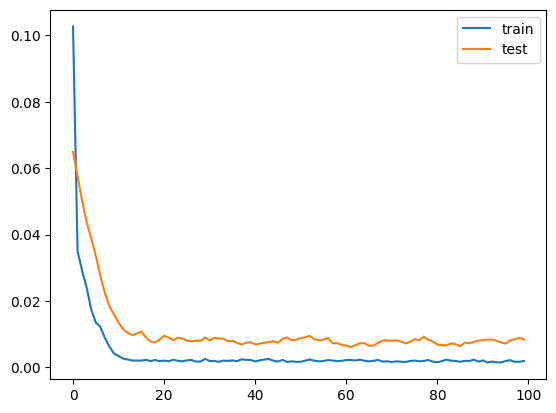

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Making Predictions

In [71]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


367/367 [==============================] - 0s 1ms/step


## Inverting Predictions

In [73]:
# Debugging shapes
print("Shape of trainPredict before adjustment:", trainPredict.shape)
print("Shape of train[:, 1:] before adjustment:", train[:, 1:].shape)

# Ensure trainPredict has the same number of rows as train[:, 1:]
if trainPredict.shape[0] != train[:, 1:].shape[0]:
    min_length = min(trainPredict.shape[0], train[:, 1:].shape[0])
    print(f"Adjusting trainPredict and train to minimum length: {min_length}")
    trainPredict = trainPredict[:min_length]
    trainY = trainY[:min_length]
    train = train[:min_length]

# Debugging shapes after adjustment
print("Shape of trainPredict after adjustment:", trainPredict.shape)
print("Shape of train[:, 1:] after adjustment:", train[:, 1:].shape)

# Inverting the predictions
trainPredict = scaler.inverse_transform(np.concatenate((trainPredict, train[:, 1:]), axis=1))[:,0]
trainY = scaler.inverse_transform(np.concatenate((trainY.reshape(-1, 1), train[:, 1:]), axis=1))[:,0]

# Debugging shapes for test data
print("Shape of testPredict before adjustment:", testPredict.shape)
print("Shape of test[:, 1:] before adjustment:", test[:, 1:].shape)

# Ensure testPredict has the same number of rows as test[:, 1:]
if testPredict.shape[0] != test[:, 1:].shape[0]:
    min_length = min(testPredict.shape[0], test[:, 1:].shape[0])
    print(f"Adjusting testPredict and test to minimum length: {min_length}")
    testPredict = testPredict[:min_length]
    testY = testY[:min_length]
    test = test[:min_length]

# Debugging shapes after adjustment
print("Shape of testPredict after adjustment:", testPredict.shape)
print("Shape of test[:, 1:] after adjustment:", test[:, 1:].shape)

# Inverting the test predictions
testPredict = scaler.inverse_transform(np.concatenate((testPredict, test[:, 1:]), axis=1))[:,0]
testY = scaler.inverse_transform(np.concatenate((testY.reshape(-1, 1), test[:, 1:]), axis=1))[:,0]

print("Inversion completed successfully.")


Shape of trainPredict before adjustment: (11738, 1)
Shape of train[:, 1:] before adjustment: (11738, 1)
Shape of trainPredict after adjustment: (11738, 1)
Shape of train[:, 1:] after adjustment: (11738, 1)
Shape of testPredict before adjustment: (11738, 1)
Shape of test[:, 1:] before adjustment: (11738, 1)
Shape of testPredict after adjustment: (11738, 1)
Shape of test[:, 1:] after adjustment: (11738, 1)
Inversion completed successfully.


## Error Metrics

In [74]:
import math 
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.6f RMSE' % (trainScore))
print('Test Score: %.6f RMSE' % (testScore))

Train Score: 0.036158 RMSE
Test Score: 0.069851 RMSE


In [75]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for training set
train_mae = mean_absolute_error(trainY, trainPredict)
print(f"Mean Absolute Error (MAE) for training set: {train_mae}")

# Calculate MAE for test set
test_mae = mean_absolute_error(testY, testPredict)
print(f"Mean Absolute Error (MAE) for test set: {test_mae}")


Mean Absolute Error (MAE) for training set: 0.029428063958878065
Mean Absolute Error (MAE) for test set: 0.06853216513254179


## Visualistaion

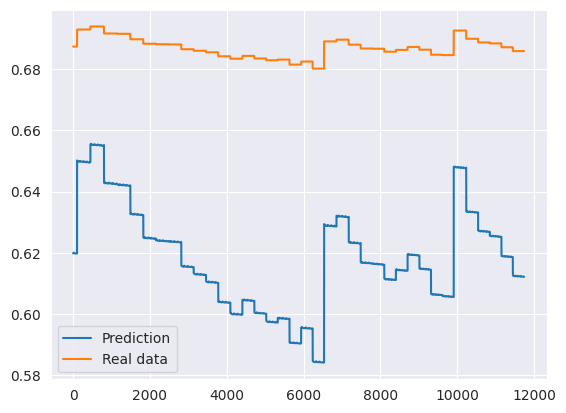

In [76]:
plt.plot(testPredict, label='Prediction')
plt.plot(testY, label='Real data')
plt.legend()
plt.show()

In [77]:
print("Shape of cycle :", np.shape(cycle))

cycle1 = cycle[0:train_size-1]
cycle2 = cycle[train_size+1:len(dataset)]

# cycle1 = cycle[0:train_size]
# cycle2 = cycle[train_size:len(dataset)]

print(np.shape(cycle1), np.shape(cycle2))

Shape of cycle : (23478,)
(11738,) (11738,)
